[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1IX6uTYvCv7NQujX6gASEhVfIQZX4-tac)

In [3]:
!pip install evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.6 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6bbdaaa52e295801d7b8a333dbcef252772cd9c8ff649488b2a4240ebbaab64d
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is

In [13]:
import torch
import json
from tqdm import tqdm
from chatbot import Chatbot, ChatbotConfig
import evaluate
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

rouge = evaluate.load("rouge")

def compute_f1(pred_tokens, ref_tokens):
    common = set(pred_tokens) & set(ref_tokens)
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(ref_tokens)
    return 2 * (precision * recall) / (precision + recall)

test_data = {
    "What is NSA in context of NUST back account?": "NUST Sahar Accounts",
    "What does PWRA stand for?": "PakWatan Remittance Account",
    "How do I delete my mobile banking account?": "for security reasons, deactivation or deletion requests must be submitted by calling the helpline at +92 (51) 111 000 494.",
    "What are the available Liability Products & Services?": "NUST Asaan Account (NAA), Little Champs Account , NUST Sahar Accounts, NUST Waqaar Account, PakWatan Remittance Account, NUST Home Remittance, RDA Digital Customer Onboarding , Current Deposit Account (CDA), Value Plus Current Account (Individual) (VPCA), Value Plus Business Account (VP-BA), Value Premium Business Account (VPBA), NUST Maximiser Account, NUST Special Deposit Account (NSDA), Profit And Loss Sharing Account (PLS), NUST Asaan Digital Account, NUST Asaan Digital Remittance Account, NUST Freelancer Digital Account.",
    "What's the daily transfer limit on the mobile banking app?": "1 million PKR. However, it can vary based on account type. You can check your specific limit in the “Limits” section of the app.",
    "What is the Target Market of Profit and Loss Sharing Account (PLS)?": "Individuals (either singly or jointly), Proprietorship Concerns, Partnership Firms, Public and Private Limited Companies, Government Organizations, Corporations, Clubs, Societies, Associations, NGOs/NPOs/Charitable Organizations",
    "can i use the mobile app while i am overseas?": "yes",
    "What is the Credit Balance Limit in NUST Freelancer Digital Account?": "USD 5,000 or equivalent",
    "What is the profit rate for PWRA?": "0.19",

	"How do I change my funds transfer limit?": "Go to “My profile” → “Manage Limit” in the app and select “Change FT/IBFT” limits.",
	"How can I add or update a funds transfer beneficiary in the app?": "Use “Transfer Funds” → “New Beneficiaries” to add or update recipient details.",
	"Can I use the app to make international transactions?": "Yes, go to card management → manage debit card → select “international tranx activation”.",
	"Does the NUST app support digital wallets or contactless payments?": "Yes, but via a separate app called NUST Digital Wallets.",
	"Can I use the app abroad?": "Yes, just ensure you have internet and your registered mobile number is active for OTPs.",
	"How can I reset my login password if I forget it?": "Tap “Forgot Password” on the login screen and follow the steps using your registered mobile number.",
	"Is biometric login available in the app?": "Yes, you can enable it via the “Profile” section under “Fingerprint Login”.",
	"What can I pay using the Bill Payment feature?": "Utility, internet, mobile bills, and government fees.",
	"How do I delete my mobile banking account?": "Call the helpline at +92 (51) 111 000 494 to request deactivation or deletion."
}

In [5]:
from huggingface_hub import login
login()

In [15]:
def benchmark(config: ChatbotConfig):
    chatbot = Chatbot(config)

    scores = []
    rouge_results = {}

    questions = list(test_data.keys())
    answers = list(test_data.values())
    preds = chatbot.multiple_queries(questions)

    for pred, ans in zip(preds, answers):      
        rouge_result = rouge.compute(predictions=[pred], references=[ans], use_stemmer=True)
        for k, v in rouge_result.items():
            rouge_results[k] = rouge_results.get(k, []) + [v]

        ans = chatbot.tokenizer.encode(ans.lower())
        pred = chatbot.tokenizer.encode(pred.lower())
        score = compute_f1(ans, pred)
        scores.append(score)
    
    scores = sum(scores) / len(scores)
    rouge_results = {k: sum(v) / len(v) for k, v in rouge_results.items()}
    # rouge_score = list(rouge_results.values())
    # rouge_score = sum(rouge_score) / len(rouge_score)

    del chatbot
    torch.cuda.empty_cache()
    gc.collect()

    return {
        "f1_score": scores,
        # "rouge_score": rouge_score,
        **rouge_results,
    }

def plot_results(results):
    # Convert to DataFrame for easy plotting
    df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'model'})
    df_melted = df.melt(id_vars='model', var_name='metric', value_name='score')
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_melted, x='metric', y='score', hue='model')
    plt.title('Model Metric Comparison')
    plt.ylim(0, 1)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

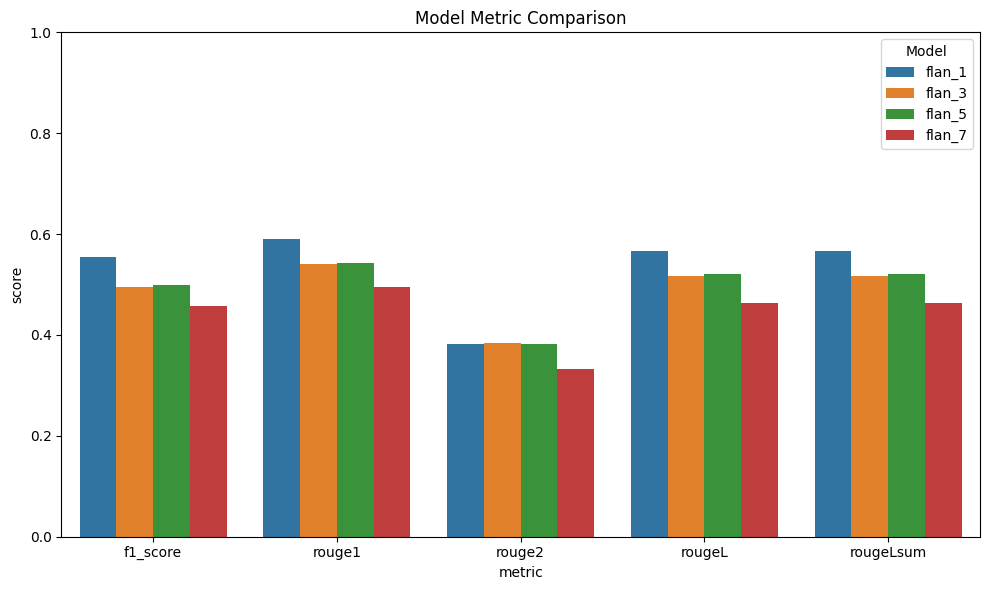

In [16]:
# top_k = {1, 3, 5, 7}

states = {
    "flan_1": ChatbotConfig(
        chatbot_model_name="google/flan-t5-large", # 783M
        top_k=1,
        device="cuda",
    ),
    "flan_3": ChatbotConfig(
        chatbot_model_name="google/flan-t5-large", # 783M
        top_k=3,
        device="cuda",
    ),
    "flan_5": ChatbotConfig(
        chatbot_model_name="google/flan-t5-large", # 783M
        top_k=5,
        device="cuda",
    ),
    "flan_7": ChatbotConfig(
        chatbot_model_name="google/flan-t5-large", # 783M
        top_k=7,
        device="cuda",
    ),
}
results = {}
for k, v in states.items():
    results[k] = benchmark(v)
plot_results(results)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

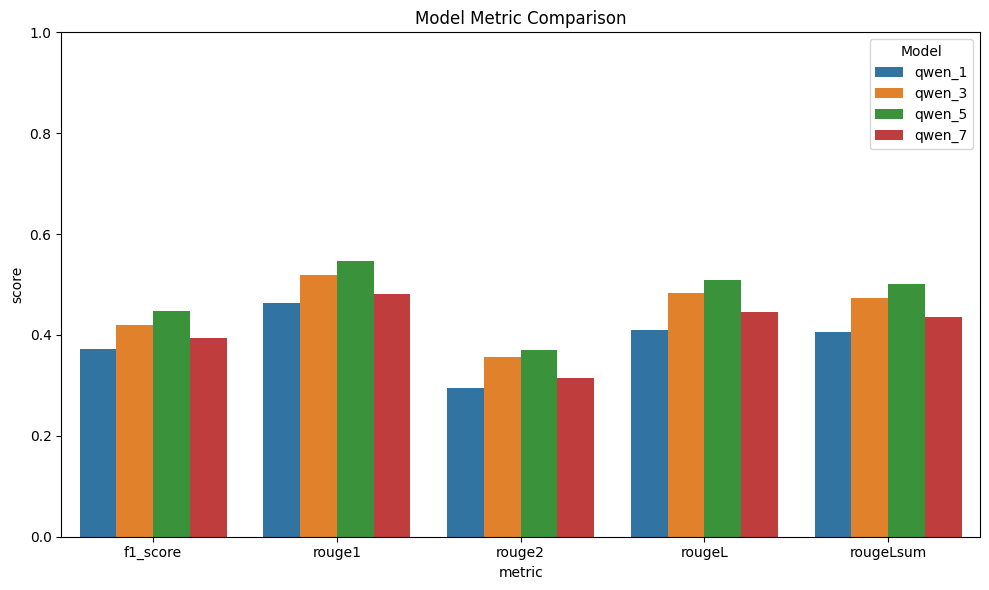

In [17]:
# top_k = {1, 3, 5, 7}

states = {
    "qwen_1": ChatbotConfig(
        chatbot_model_name="Qwen/Qwen3-0.6B",
        top_k=1,
        device="cuda",
    ),
    "qwen_3": ChatbotConfig(
        chatbot_model_name="Qwen/Qwen3-0.6B",
        top_k=3,
        device="cuda",
    ),
    "qwen_5": ChatbotConfig(
        chatbot_model_name="Qwen/Qwen3-0.6B",
        top_k=5,
        device="cuda",
    ),
    "qwen_7": ChatbotConfig(
        chatbot_model_name="Qwen/Qwen3-0.6B",
        top_k=7,
        device="cuda",
    ),
}
results = {}
for k, v in states.items():
    results[k] = benchmark(v)
plot_results(results)

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


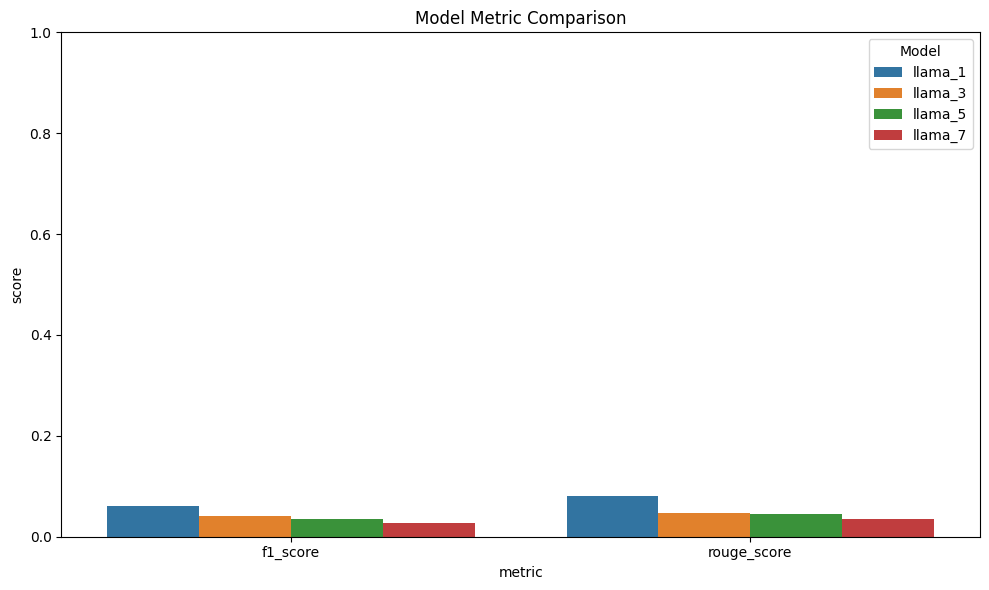

In [9]:
# top_k = {1, 3, 5, 7}

states = {
    "llama_1": ChatbotConfig(
        chatbot_model_name="meta-llama/Llama-3.2-1B",
        top_k=1,
        device="cuda",
    ),
    "llama_3": ChatbotConfig(
        chatbot_model_name="meta-llama/Llama-3.2-1B",
        top_k=3,
        device="cuda",
    ),
    "llama_5": ChatbotConfig(
        chatbot_model_name="meta-llama/Llama-3.2-1B",
        top_k=5,
        device="cuda",
    ),
    "llama_7": ChatbotConfig(
        chatbot_model_name="meta-llama/Llama-3.2-1B",
        top_k=7,
        device="cuda",
    ),
}
results = {}
for k, v in states.items():
    results[k] = benchmark(v)
plot_results(results)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

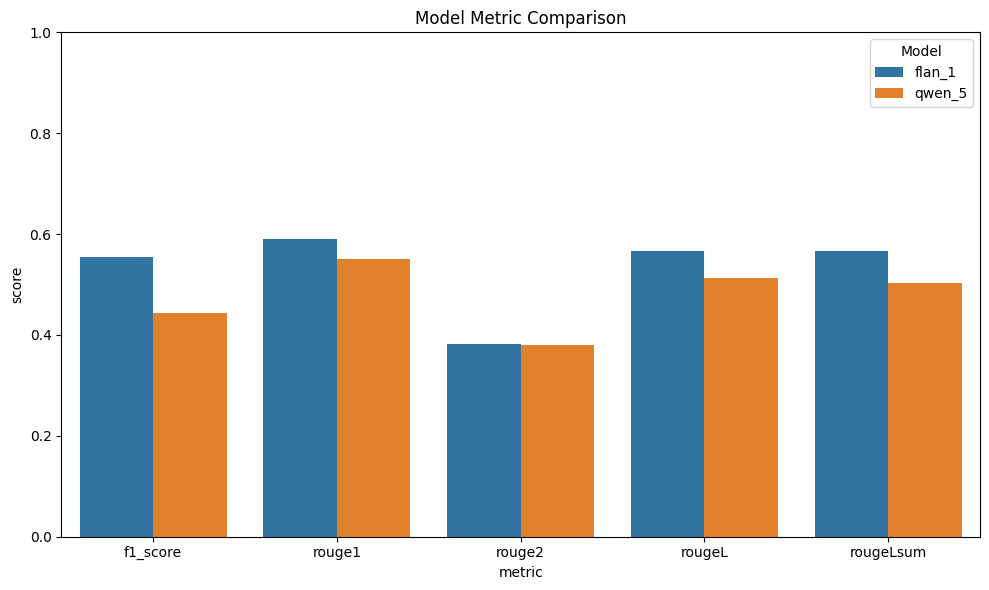

In [19]:
# model = {flan, qwen, llama}

states = {
    # "llama_1": ChatbotConfig(
    #     chatbot_model_name="meta-llama/Llama-3.2-1B",
    #     top_k=1,
    #     device="cuda",
    # ),
    "flan_1": ChatbotConfig(
        chatbot_model_name="google/flan-t5-large", # 783M
        top_k=1,
        device="cuda",
    ),
    "qwen_5": ChatbotConfig(
        chatbot_model_name="Qwen/Qwen3-0.6B", # 752M
        top_k=5,
        device="cuda",
    ),
}
results = {}
for k, v in states.items():
    results[k] = benchmark(v)
plot_results(results)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

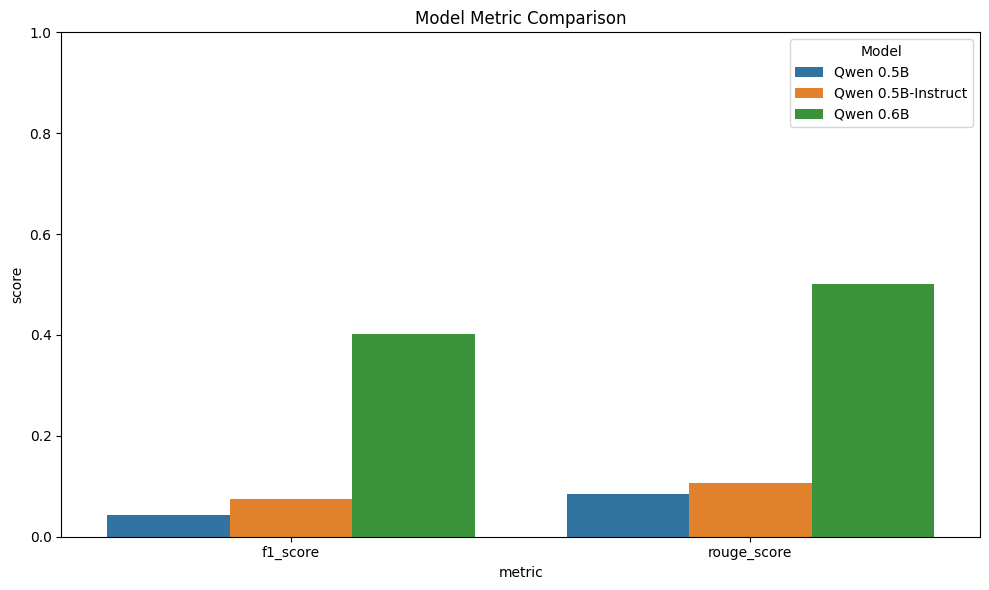

In [11]:
# model = {flan, qwen, llama}

states = {
    "Qwen 0.5B": ChatbotConfig(
        chatbot_model_name="Qwen/Qwen2.5-0.5B",
        top_k=5,
        device="cuda",
    ),
    "Qwen 0.5B-Instruct": ChatbotConfig(
        chatbot_model_name="Qwen/Qwen2.5-0.5B-Instruct",
        top_k=5,
        device="cuda",
    ),
    "Qwen 0.6B": ChatbotConfig(
        chatbot_model_name="Qwen/Qwen3-0.6B",
        top_k=5,
        device="cuda",
    ),
    # "Qwen 0.6B-FP8": ChatbotConfig(
    #     chatbot_model_name="Qwen/Qwen3-0.6B-FP8",
    #     top_k=5,
    #     device="cuda",
    # ),
}
results = {}
for k, v in states.items():
    results[k] = benchmark(v)
plot_results(results)